# Inverse transforms

UMAP has some support for inverse transforms -- generating a high dimensional data sample given a location in the low dimensional embedding space. To start let's load all the relavent libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sklearn.datasets
import umap
import umap.plot

We will need some data to test with. To start we'll use the MNIST digits dataset. This is a dataset of 70000 handwritten digits encoded as grayscale 28x28 pixel images. Our goal is to use UMAP to reduce the dimension of this dataset to something small, and then see if we can generate new digits by sampling points from the embedding space. To load the MNIST dataset we'll make use of sklearn's ``fetch_openml`` function.

In [2]:
data, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

Now we need to generate a reduced dimension representation of this data. This is straightforward with umap, but in this case rather than using ``fit_transform`` we'll use the fit method so that we can retain the trained model for later generating new digits based on samples from the embedding space.

In [3]:
mapper = umap.UMAP(random_state=42).fit(data)

To ensure that things worked correctly we can plot the data (since we reduced it to two dimensions). We'll use the ``umap.plot`` functionality to do this.

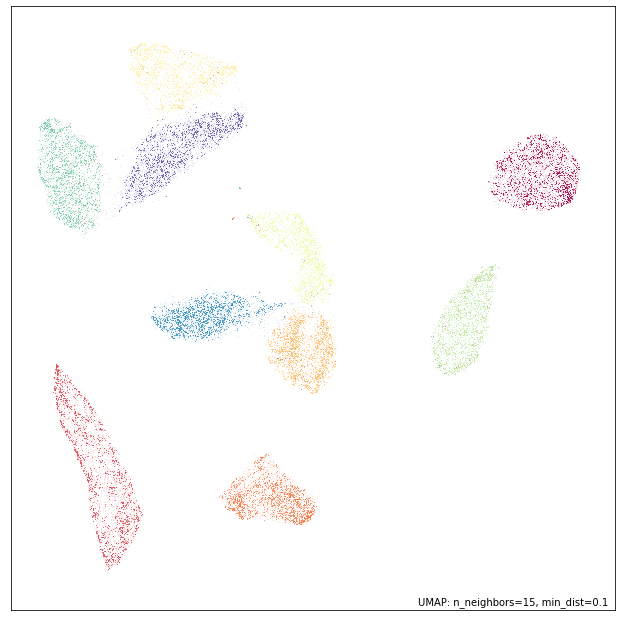

In [4]:
umap.plot.points(mapper, labels=labels)

This looks much like we would expect. The different digit classes have been decently separated. Now we need to create a set of samples in the emebdding space to apply the ``inverse_transform`` operation to. To do this we'll generate a grid of samples linearly interpolating between four corner points. To make out selection interesting we'll carefully choose the corners to span over the dataset, and sample different digits so that we can better see the transitions.

In [5]:
corners = np.array([
    [-5, -10],  # 1
    [-7, 6],  # 7
    [2, -8],  # 2
    [12, 4],  # 0
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

Now we can apply the ``inverse_transform`` method to this set of test points. Each test point is a two dimensional point lying somewhere in the embedding space. The ``inverse_transform`` method will convert this in to an approximation of the high dimensional representation that would have been embedded into such a location. Following the sklearn API this is as simple to use as calling the ``inverse_transform`` method of the trained model and passing it the set of test points that we want to convert into high dimensional representations. Be warned that this can be quite expensive computationally.

In [6]:
inv_transformed_points = mapper.inverse_transform(test_pts)

Now the goal is to visualize how well we have done. Effectively what we would like to do is show the test points in the embedding space, and then show a grid of the corresponding images generated by the inverse transform. To get all of this in a single matplotlib figure takes a little setting up, but is quite manageable -- mostly it is just a matter of managing ``GridSpec`` formatting. Once we have that setup we just need a scatterplot of the embedding, a scatterplot of the test points, and finally a grid of the images we generated (converting the inverse transformed vectors into images is just a matter of reshaping them back to 28 by 28 pixel grids and using ``imshow``).

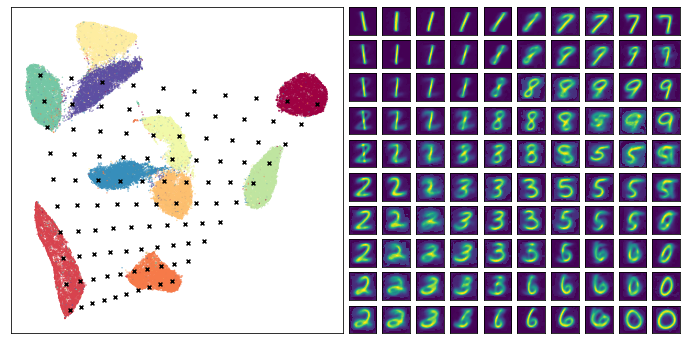

In [7]:
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])

The end result looks pretty good -- we did indeed generate plausible looking digit images, and many of the transitions (from 1 to 7 across the top row for example) seem pretty natural and make sense. This can help you to understand the structure of the cluster of 1s (it transitions on the angle, sloping toward what will eventually be 7s), and why 7s and 9s are close together in the embedding. Of course there are also some stranger transitions, especially where the test points fell into large gaps between clusters in the embedding -- in some sense it is hard to interpret what should go in some of those gaps as they don't really represent anything resembling a smooth transition).

A further note: None of the test points chosen fall outside the convex hull of the embedding. This is deliberate -- the inverse transform function operates poorly outside the bounds of that convex hull. Be warned that if you select points to inverse transform that are outside the bounds about the embedding you will likely get strange results (often simply snapping to a particular source high dimensional vector).

Let's continue the demonstration by looking at the Fashion MNIST dataset. As before we can load this through sklearn.

In [8]:
data, labels = sklearn.datasets.fetch_openml('Fashion-MNIST', version=1, return_X_y=True)

Again we can fit this data with UMAP and get a mapper object.

In [9]:
mapper = umap.UMAP(random_state=42).fit(data)

Let's plot the embedding to see what we got as a result:

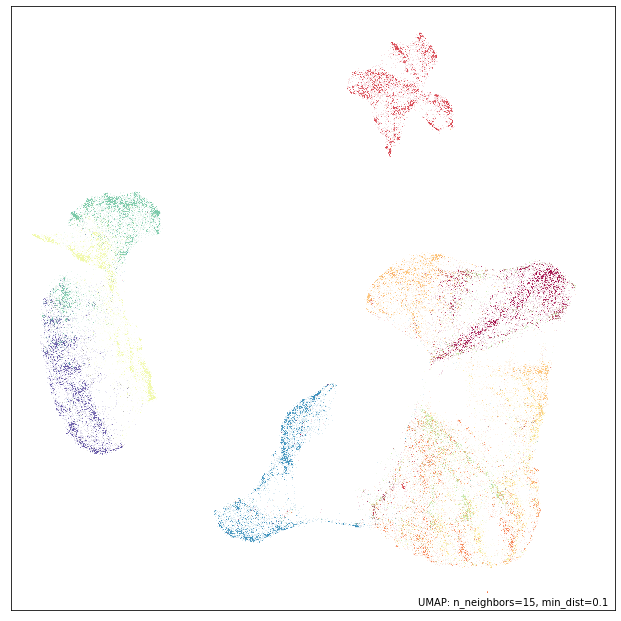

In [10]:
umap.plot.points(mapper, labels=labels)

Again we'll generate a set of test points by making a grid interpolating between four corners. As before we'll select the corners so that we can stay within the convex hull of the embedding points and ensure nothign to strange happens with the inverse transforms.

In [14]:
corners = np.array([
    [-2, -6],  # bags
    [-9, 3],  # boots?
    [7, -5],  # shirts/tops/dresses
    [4, 10],  # pants
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

Now we simply apply the inverse transform just as before. Again, be warned, this is quite expensive computationally and may take some time to complete.

In [12]:
inv_transformed_points = mapper.inverse_transform(test_pts)

And now we can use similar code as above to set up out plot of the embedding with test points overlaid, and the generated images.

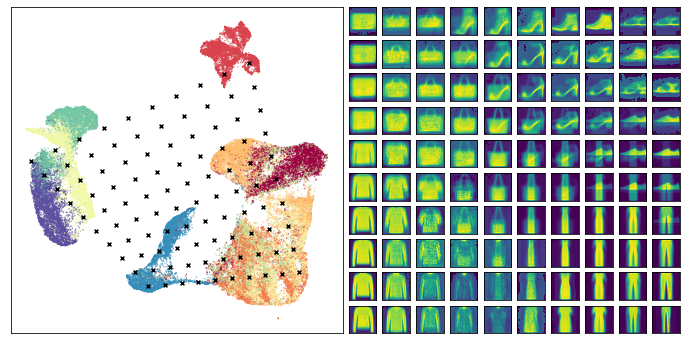

In [15]:
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])

This time we see some of the interpolations between items looking rather strange -- particularly the points that lie somewhere between shoes and pants -- ultimately it is doing the best it can with a difficult problem. At the same time many of the other transitions seem to work pretty well, so it is, indeed, providing useful information about how the embedding is structured. 